In [103]:
import numpy as np
import codecs

def get_embeddings():
    with codecs.open("/home/embeddings", "r", "utf-8") as f:
            elems = f.readline().strip().split()
            if len(elems) == 2:
                header = True
                dim = int(elems[1])
            else:
                header = False
                dim = len(elems)-1
    words = []
    word2vec = {}
    with codecs.open("/home/embeddings", "r", "utf-8") as f:
        line_count = 0
        if header:
            f.readline()
            line_count = 1
        for line in f:
            line_count += 1
            elems = line.strip().split()
            if len(elems) == dim + 1:
                word = elems[0]
                try:
                    vec = np.asarray(elems[1:], dtype=np.float32)
                    words.append(word)
                    word2vec[word] = vec
                except ValueError as e:
                    print("ValueError: Skipping line {}".format(line_count))
            else:
                msg = "Error: Skipping line {}. ".format(line_count)
                msg += "Expected {} elements, found {}.".format(dim+1, len(elems))
        print(line_count)
                
    return words, word2vec

In [104]:
words, word2vec = get_embeddings()

209063


In [105]:
print(len(words))

209062


In [106]:
embeddings = []
for embed in word2vec.values():
    embeddings.append(list(embed))
embeddings = np.array(embeddings)

In [107]:
word_mapping = {}
for i in range(len(words)):
    word_mapping[words[i]] = i

In [109]:
def subtask_file_mapping(subtask):
    mapping ={"1A": "1A.english", "2A": "2A.medical", "2B": "2B.music", "1B": "1B.italian", "1C": "1C.spanish"}
    return mapping[subtask]

In [110]:
def load_data(subtask, datadir, split):
    if(split == "train"):
        split = "training"
    data = []
    gold = {}
    data_path = f'{datadir}/{split}/data/{subtask_file_mapping(subtask)}.{split}.data.txt'
    gold_path = f'{datadir}/{split}/gold/{subtask_file_mapping(subtask)}.{split}.gold.txt'
    with open(data_path, 'r') as f:
        lines = f.read().split('\n')
        print(len(lines))
        for line in lines:
            word = line.split('\t')[0].lower()
            word = word.replace(" ", "_")
            data.append(word)
    with open(gold_path, 'r') as f:
        lines = f.read().split('\n')
        for i,line in enumerate(lines):
            gold_data = []
            golds = line.lower().split('\t') 
            for gold_word in golds:
                gold_data.append(gold_word.replace(" ", "_"))
            gold[data[i]] = gold_data
            
    return data, gold
test_data, test_gold = load_data("1A", "SemEval2018-Task9", "test")
train_data, train_gold  = load_data("1A", "SemEval2018-Task9", "train")


1500
1500


In [113]:
array1 = np.array([1,2,3])
array2 = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(np.dot(array2, array1))
print(np.dot(array1, array2) /(np.linalg.norm(array2, axis = 1) * np.linalg.norm(array1)))

[14 32 50]
[2.14285714 1.09646083 0.80590603]


In [114]:
def make_embedding_matrix(word2vec, words, seed=0):
    np.random.seed(seed)
    dim = 200
    dtype = np.float32
    matrix = np.zeros((len(words), dim), dtype=dtype)
    count = 0
    for (i,word) in enumerate(words):
        if word in word2vec.keys():
            matrix[i] = word2vec[word]
        else:
            count += 1
            matrix[i] = np.random.uniform(low=-0.5, high=0.5) / dim
    return matrix


In [115]:
import numpy as np

def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector2, vector1)
    magnitude1 = np.linalg.norm(vector1)
    magnitude2 = np.linalg.norm(vector2, axis = 1)
    similarity = dot_product / (magnitude1 * magnitude2)
    return similarity

In [116]:
def get_top_k(test_data,train_data, k=20):
    test_embeddings = make_embedding_matrix(word2vec, test_data)
    train_embeddings = make_embedding_matrix(word2vec, train_data)
    top_k = []
    for data in test_embeddings:
        similarities = cosine_similarity(data, train_embeddings)
        
        top_indices = np.argsort(similarities)[-k:]
        
        top_words  =list(np.array(train_data)[top_indices])
        top_k.append(top_words)
    return top_k
top_k = get_top_k(test_data, train_data)
    

In [117]:
def get_hypernyms(test_data, top_hyponyms, train_gold, words, n=15):
    test_embeddings = make_embedding_matrix(word2vec, test_data)
    top_n = []
    array_words = np.array(words)
    for i,data in enumerate(test_embeddings):
        candidates = set()
        for hypo in top_hyponyms[i]:
            for candidate in train_gold[hypo]:
                candidates.add(candidate)
        superset_candidates = candidates.copy()
        
        candidates = list(candidates)
        candidate_embeddings = make_embedding_matrix(word2vec, candidates)
        
        similarities = cosine_similarity(data, candidate_embeddings)
        top_indices = np.argsort(similarities)[-n:]
        top_words  =list(np.array(candidates)[top_indices][::-1])
        top_n.append(top_words)
    return top_n
hypernyms = get_hypernyms(test_data, top_k, train_gold, words)

In [120]:
try:
    with open('NN_predicted_processed_clustered.txt', 'w') as file:
        for inner_list in hypernyms:
            line = '\t'.join(map(str, inner_list))
            file.write(line + '\n')
    print("List of lists has been written to the file successfully.")
except IOError:
    print(f"Error writing to the file '{file_path}'.")

List of lists has been written to the file successfully.


In [122]:
try:
    # Open the file in write mode
    with open('test_gold_processed.txt', 'w') as file:
        # Iterate over each list in the list of lists
        for inner_list in list(test_gold.values()):
            # Convert the inner list to a string with elements separated by commas
            line = '\t'.join(map(str, inner_list))
            # Write the line to the file
            file.write(line + '\n')
    print("List of lists has been written to the file successfully.")
except IOError:
    print(f"Error writing to the file '{file_path}'.")

List of lists has been written to the file successfully.


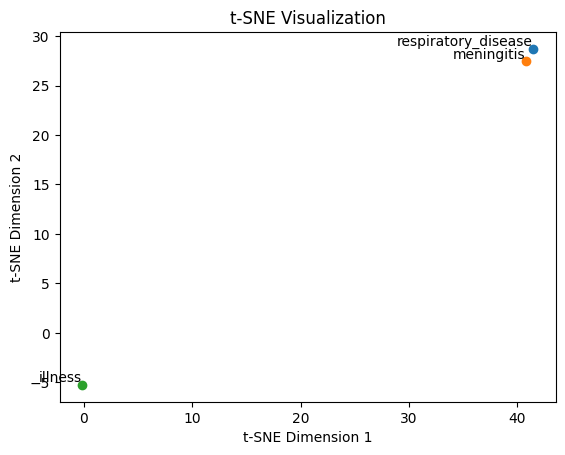

In [170]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(embeddings_2d[10000, 0], embeddings_2d[10000, 1])
plt.text(embeddings_2d[10000, 0], embeddings_2d[10000, 1], "respiratory_disease", fontsize=10, ha='right', va='bottom')
plt.scatter(embeddings_2d[10001, 0], embeddings_2d[10001, 1])
plt.text(embeddings_2d[10001, 0], embeddings_2d[10001, 1], "meningitis", fontsize=10, ha='right', va='bottom')
plt.scatter(embeddings_2d[2424, 0], embeddings_2d[2424, 1])
plt.text(embeddings_2d[2424, 0], embeddings_2d[2424, 1], "illness", fontsize=10, ha='right', va='bottom')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('2.png')
plt.show()
